11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generator summary:


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 28, 28, 1)      │     1,924,289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,924,289 (7.34 MB)

 Trainable params: 1,923,905 (7.34 MB)

 Non-trainable params: 384 (1.50 KB)


Discriminator summary:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 1)              │       139,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,073 (543.25 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 139,073 (543.25 KB)


Generating sample images without training...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step


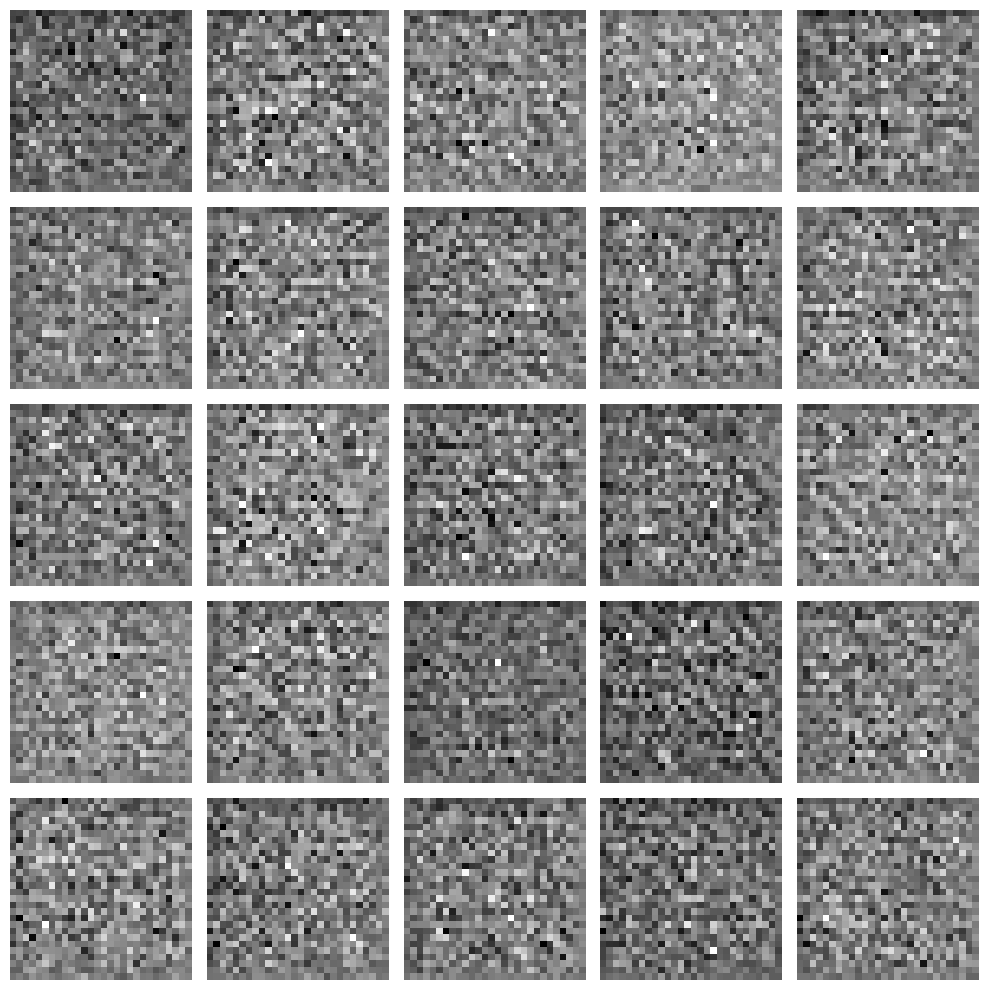


To train the GAN fully:
1. Uncomment the train_gan line
2. Adjust the number of epochs as needed (5000 is a good starting point)
3. Run the cell

Note: Training a GAN takes significant time. For a complete run, you may need 
to increase the Colab runtime to GPU and expect it to take several hours.



In [1]:
# Generative Adversarial Network (GAN) Implementation
# For Google Colab

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Reshape, Flatten, Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the MNIST dataset
(x_train, _), (_, _) = mnist.load_data()

# Normalize the images to [-1, 1]
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)

# Parameters
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100  # Dimension of noise vector
batch_size = 128
epochs = 10000
sample_interval = 1000  # Interval between image sampling

# Build the Generator
def build_generator():
    model = Sequential()

    # Foundation for 7x7 image
    model.add(Dense(7*7*256, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 256)))

    # Upsample to 14x14
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # Upsample to 28x28
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # Output layer with tanh activation
    model.add(Conv2D(channels, kernel_size=4, padding='same', activation='tanh'))

    # Noise input
    z = Input(shape=(z_dim,))
    # Generated image
    img = model(z)

    return Model(z, img)

# Build the Discriminator
def build_discriminator():
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))

    # Second convolutional layer
    model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # Flatten and output layer
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    # Image input
    img = Input(shape=img_shape)
    # Validity output
    validity = model(img)

    return Model(img, validity)

# Build and compile the Discriminator
discriminator = build_discriminator()
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    metrics=['accuracy']
)

# Build the Generator
generator = build_generator()

# The Generator takes noise as input and generates images
z = Input(shape=(z_dim,))
img = generator(z)

# For the combined model, we only train the Generator
discriminator.trainable = False

# The Discriminator takes generated images as input and determines validity
validity = discriminator(img)

# The combined model (stacked Generator and Discriminator)
combined = Model(z, validity)
combined.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5)
)

# Display model summaries
print("Generator summary:")
generator.summary()

print("\nDiscriminator summary:")
discriminator.summary()

# Function to save generated images
def save_images(epoch):
    rows, cols = 5, 5
    noise = np.random.normal(0, 1, (rows * cols, z_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
    count = 0
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(gen_imgs[count, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            count += 1

    fig.savefig(f"gan_images_epoch_{epoch}.png")
    plt.close()

# Train the GAN
def train_gan(epochs, batch_size, sample_interval):
    # Create arrays for logging losses
    d_losses = []
    g_losses = []

    # Labels for real and fake images
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(1, epochs + 1):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of real images
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_imgs = x_train[idx]

        # Generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Generate new noise samples
        noise = np.random.normal(0, 1, (batch_size, z_dim))

        # Train the generator (want the discriminator to mistake images as real)
        g_loss = combined.train_on_batch(noise, valid)

        # Store losses for plotting
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)

        # Print progress
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs} | D Loss: {d_loss[0]:.4f} | D Accuracy: {100*d_loss[1]:.2f}% | G Loss: {g_loss:.4f}")

        # If at save interval, generate and save images
        if epoch % sample_interval == 0:
            save_images(epoch)

            # Also plot losses
            plt.figure(figsize=(10, 5))
            plt.plot(d_losses, label='Discriminator Loss')
            plt.plot(g_losses, label='Generator Loss')
            plt.title('GAN Losses')
            plt.xlabel('Epoch / 100')  # If plotting every 100 epochs
            plt.ylabel('Loss')
            plt.legend()
            plt.savefig(f'gan_losses_epoch_{epoch}.png')
            plt.close()

    return d_losses, g_losses

# For Colab demonstration, we'll train for a smaller number of epochs
# Uncomment the following line to train the GAN
# d_losses, g_losses = train_gan(epochs=5000, batch_size=batch_size, sample_interval=1000)

# For demonstration purposes, just generate some random images
print("\nGenerating sample images without training...")
noise = np.random.normal(0, 1, (25, z_dim))
gen_imgs = generator.predict(noise)
gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]

# Plot generated images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(gen_imgs[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

print("""
To train the GAN fully:
1. Uncomment the train_gan line
2. Adjust the number of epochs as needed (5000 is a good starting point)
3. Run the cell

Note: Training a GAN takes significant time. For a complete run, you may need
to increase the Colab runtime to GPU and expect it to take several hours.
""")